## Traveling Salesman Problem using Quantum Approximate Optimization Algorithm (QAOA)
(Reference : https://github.com/qiskit-community/qiskit-optimization/blob/main/docs/tutorials/06_examples_max_cut_and_tsp.ipynb )

In addition to being a notorious NP-complete problem that has drawn the attention of computer scientists and mathematicians for over two centuries, the Traveling Salesman Problem (TSP) has important bearings on finance and marketing, as its name suggests. Colloquially speaking, the traveling salesman is a person that goes from city to city to sell merchandise. The objective in this case is to find the shortest path that would enable the salesman to visit all the cities and return to his hometown, i.e. the city where he started traveling. By doing this, the salesman gets to maximize potential sales in the least amount of time. 

The problem derives its importance from its "hardness" and ubiquitous equivalence to other relevant combinatorial optimization problems that arise in practice.
 
The mathematical formulation with some early analysis was proposed by W.R. Hamilton in the early 19th century. Mathematically the problem is, as in the case of Max-Cut, best abstracted in terms of graphs. The TSP on the nodes of a graph asks for the shortest *Hamiltonian cycle* that can be taken through each of the nodes. A Hamiltonian cycle is a closed path that uses every vertex of a graph once. The general solution is unknown and an algorithm that finds it efficiently (e.g., in polynomial time) is not expected to exist.

Find the shortest Hamiltonian cycle in a graph $G=(V,E)$ with $n=|V|$ nodes and distances, $w_{ij}$ (distance from vertex $i$ to vertex $j$). A Hamiltonian cycle is described by $N^2$ variables $x_{i,p}$, where $i$ represents the node and $p$ represents its order in a prospective cycle. The decision variable takes the value 1 if the solution occurs at node $i$ at time order $p$. We require that every node can only appear once in the cycle, and for each time a node has to occur. This amounts to the two constraints (here and in the following, whenever not specified, the summands run over 0,1,...N-1)

$$\sum_{i} x_{i,p} = 1 ~~\forall p$$
$$\sum_{p} x_{i,p} = 1 ~~\forall i.$$

For nodes in our prospective ordering, if $x_{i,p}$ and $x_{j,p+1}$ are both 1, then there should be an energy penalty if $(i,j) \notin E$ (not connected in the graph). The form of this penalty is 

$$\sum_{i,j\notin E}\sum_{p} x_{i,p}x_{j,p+1}>0,$$ 

where it is assumed the boundary condition of the Hamiltonian cycles $(p=N)\equiv (p=0)$. However, here it will be assumed a fully connected graph and not include this term. The distance that needs to be minimized is 

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}.$$

Putting this all together in a single objective function to be minimized, we get the following:

$$C(\textbf{x})=\sum_{i,j}w_{ij}\sum_{p} x_{i,p}x_{j,p+1}+ A\sum_p\left(1- \sum_i x_{i,p}\right)^2+A\sum_i\left(1- \sum_p x_{i,p}\right)^2,$$

where $A$ is a free parameter. One needs to ensure that $A$ is large enough so that these constraints are respected. One way to do this is to choose $A$ such that $A > \mathrm{max}(w_{ij})$.

Once again, it is easy to map the problem in this form to a quantum computer, and the solution will be found by minimizing a Ising Hamiltonian. 

In [1]:
import numpy as np
import networkx as nx
from qiskit import QuantumCircuit, transpile
from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.translators import to_ising

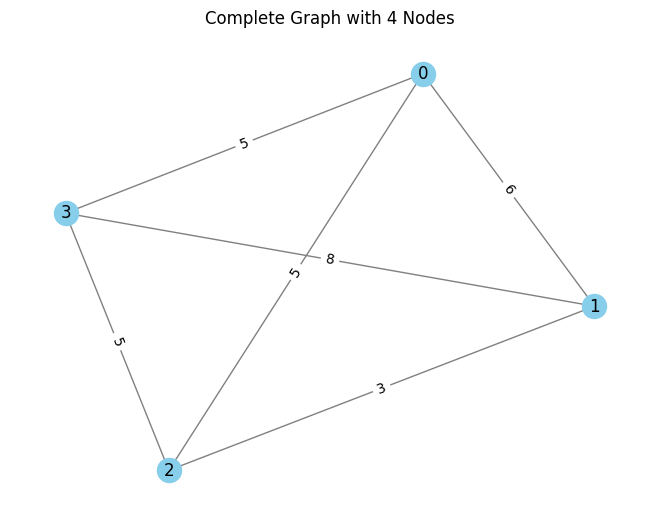

In [2]:
n = 4  # Number of cities/nodes
num_qubits = n**2

# Create a complete graph with n nodes
G = nx.complete_graph(n)


# Optionally, add random weights (e.g., distances)
import numpy as np
for (u, v) in G.edges():
    G[u][v]['weight'] = np.random.randint(1, 10)  # Random weight between 1 and 9

# Draw the graph

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title(f"Complete Graph with {n} Nodes")
plt.show()

# Define TSP instance
tsp = Tsp(G)
# tsp.pos =pos

num_cities = n
num_positions = n

In [3]:
# Convert TSP to Quadratic Program
qp = tsp.to_quadratic_program()

# Convert Quadratic Program to QUBO
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)


In [4]:
backend = AerSimulator() #using qiskit Aer Simulator to perform simulation.

In [5]:
#Converting the QUBO to Hamiltonian
hamiltonian, offset = to_ising(qubo)
print(hamiltonian.paulis)

[np.str_('IIIIIIIIIIIIIIIZ'), np.str_('IIIIIIIIIIIIIIZI'),
 np.str_('IIIIIIIIIIIIIZII'), np.str_('IIIIIIIIIIIIZIII'),
 np.str_('IIIIIIIIIIIZIIII'), np.str_('IIIIIIIIIIZIIIII'),
 np.str_('IIIIIIIIIZIIIIII'), np.str_('IIIIIIIIZIIIIIII'),
 np.str_('IIIIIIIZIIIIIIII'), np.str_('IIIIIIZIIIIIIIII'),
 np.str_('IIIIIZIIIIIIIIII'), np.str_('IIIIZIIIIIIIIIII'),
 np.str_('IIIZIIIIIIIIIIII'), np.str_('IIZIIIIIIIIIIIII'),
 np.str_('IZIIIIIIIIIIIIII'), np.str_('ZIIIIIIIIIIIIIII'),
 np.str_('IIIIIIIIIIIIIIZZ'), np.str_('IIIIIIIIIIIIIZIZ'),
 np.str_('IIIIIIIIIIIIZIIZ'), np.str_('IIIIIIIIIIIZIIIZ'),
 np.str_('IIIIIIIIIIZIIIIZ'), np.str_('IIIIIIIIZIIIIIIZ'),
 np.str_('IIIIIIIZIIIIIIIZ'), np.str_('IIIIIIZIIIIIIIIZ'),
 np.str_('IIIIZIIIIIIIIIIZ'), np.str_('IIIZIIIIIIIIIIIZ'),
 np.str_('IIZIIIIIIIIIIIIZ'), np.str_('ZIIIIIIIIIIIIIIZ'),
 np.str_('IIIIIIIIIIIIIZZI'), np.str_('IIIIIIIIIIIIZIZI'),
 np.str_('IIIIIIIIIIIZIIZI'), np.str_('IIIIIIIIIIZIIIZI'),
 np.str_('IIIIIIIIIZIIIIZI'), np.str_('IIIIIIIZIIIIIIZI'

In [6]:
print(hamiltonian.coeffs)

[-522.  +0.j -522.  +0.j -522.  +0.j -522.  +0.j -522.5 +0.j -522.5 +0.j
 -522.5 +0.j -522.5 +0.j -520.5 +0.j -520.5 +0.j -520.5 +0.j -520.5 +0.j
 -523.  +0.j -523.  +0.j -523.  +0.j -523.  +0.j  128.5 +0.j  128.5 +0.j
  128.5 +0.j  128.5 +0.j    1.5 +0.j    1.5 +0.j  128.5 +0.j    1.25+0.j
    1.25+0.j  128.5 +0.j    1.25+0.j    1.25+0.j  128.5 +0.j  128.5 +0.j
    1.5 +0.j  128.5 +0.j    1.5 +0.j    1.25+0.j  128.5 +0.j    1.25+0.j
    1.25+0.j  128.5 +0.j    1.25+0.j  128.5 +0.j    1.5 +0.j  128.5 +0.j
    1.5 +0.j    1.25+0.j  128.5 +0.j    1.25+0.j    1.25+0.j  128.5 +0.j
    1.25+0.j    1.5 +0.j    1.5 +0.j  128.5 +0.j    1.25+0.j    1.25+0.j
  128.5 +0.j    1.25+0.j    1.25+0.j  128.5 +0.j  128.5 +0.j  128.5 +0.j
  128.5 +0.j  128.5 +0.j    0.75+0.j    0.75+0.j  128.5 +0.j    2.  +0.j
    2.  +0.j  128.5 +0.j  128.5 +0.j    0.75+0.j  128.5 +0.j    0.75+0.j
    2.  +0.j  128.5 +0.j    2.  +0.j  128.5 +0.j    0.75+0.j  128.5 +0.j
    0.75+0.j    2.  +0.j  128.5 +0.j    2.  +0.j   

In [7]:
# setting QAOA depth
p = 1 

gammas=[]
betas=[]
params = gammas+betas

#Creating QAOA circuit with Cost/problem hamiltonian and Mixer hamiltonian (encoding evolution of Hamiltonians in Q-circuit)
def create_qaoa_circuit(params):
    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))
    
    for idx, param in enumerate(params):
        if idx < len(params)/2:
            gammas.append(param)
        else:
            betas.append(param)
            
    for gamma, beta in zip(gammas, betas):
        # Problem Hamiltonian
        for pauli, coeff in zip(hamiltonian.paulis, hamiltonian.coeffs):
            z_indices = np.where(pauli.z)[0]
            if len(z_indices) > 1:
                qc.rzz(2 * coeff.real * gamma, z_indices[0], z_indices[1])
            else:
                qc.rz(2 * coeff.real * gamma, z_indices[0])

        # Mixer Hamiltonian
        for qubit in range(num_qubits):
            qc.rx(2 * beta, qubit)

    qc.measure_all()
    return qc


In [8]:
#Finding the expectation value (energy) of the hamiltonian 
def compute_energy(bitstring, hamiltonian):
    z_values = 1 - 2 * np.array([int(bit) for bit in reversed(bitstring)])  # Map 0→+1, 1→–1
    energy = 0.0

    for pauli, coeff in zip(hamiltonian.paulis, hamiltonian.coeffs):
        term_val = coeff.real
        for idx, is_z in enumerate(pauli.z):
            if is_z:
                term_val *= z_values[idx]
        energy += term_val
        # print(energy)
    return energy

def qaoa_objective(params):
    # gamma_val, beta_val = params
    qc = create_qaoa_circuit(params)
    qc = transpile(qc, backend)
    result = backend.run(qc, shots=2048).result()
    counts = result.get_counts()

    total_energy = 0
    total_counts = sum(counts.values())
    for bitstring, count in counts.items():
        total_energy += compute_energy(bitstring, hamiltonian) * count
    return total_energy / total_counts 


In [9]:
#Optimizing the circuit paramters used while encoding the Q-circuit

# Initial parameters
params0=np.array([0.1 for i in range(2*p)]) 

# Classical optimization
res = minimize(qaoa_objective, params0, method='COBYLA')
optimal_params = res.x
optimal_gamma= optimal_params[0]
optimal_beta= optimal_params[1]
print("Optimal γ, β:", optimal_gamma, optimal_beta)

Optimal γ, β: 1.1000316898871303 0.10009484593324794


In [34]:
# optimal_gamma_n4 = optimal_gamma
# optimal_beta_n4 = optimal_beta
# G_n4 = G
# pos_n4 = nx.spring_layout(G, seed=42)
# labels_n4 = nx.get_edge_attributes(G, 'weight')

nx.draw(G_n4, pos_n4, with_labels=True, node_color='skyblue', edge_color='gray')
nx.draw_networkx_edge_labels(G_n4, pos_n4, edge_labels=labels_n4)
plt.title(f"Complete Graph with 4 Nodes")
plt.show()

optimal_params = [optimal_gamma_n4, optimal_beta_n4]

NameError: name 'G_n4' is not defined

In [10]:
#Running the Q-circuit with optimal paramters and getting the results. 

qc = create_qaoa_circuit(optimal_params)
qc = transpile(qc, backend)
result = backend.run(qc, shots=8192).result()
counts = result.get_counts()
sorted_counts = sorted(counts, key=counts.get, reverse=True)

In [11]:
#Function to find feasible solution out of all the optimal solutions. 
def feasible_solution(solution):
    flag = False
    sol = np. array([int(b) for b in reversed(solution)]).reshape(num_cities, num_positions) #edited (order reversed in reshape)
    # print(sol)
    indices=[]
    for i in range(num_cities):
        # print(i)
        if len(np.where(sol[:,i]==1)[0]) != 1 and flag==False: #find if more than 1 cities visited at a time
            flag = True
        elif flag==False:                                #find if same city visitied more than once
            indices.append(np.where(sol[:,i]==1)[0].item())
            if len(np.unique(indices)) <= i:
                flag = True
    
    if flag == False:
        print("Feasible solution found !!!")
        print(sol)
        # tour = np.where(sol[:,0])
        tour = [np.where(sol[:,k])[0][0] for k in range(num_positions)]
        return tour
    else:
        # print("Feasible solution not found.")
        return None
            

In [12]:
def optimal_tour(tour):
    tour.append(tour[0])
    tour_track = ""
    for i in range(len(tour)):
        if i+1 < len(tour):
            tour_track += str(tour[i].item()) + ' -> '
            
        else:
            tour_track += str(tour[i].item())
    print(tour_track)

for bitstring in sorted_counts:
    tour = feasible_solution(bitstring)
    
    if tour != None:
        optimal_tour(tour)
        break
        

Feasible solution found !!!
[[0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]
1 -> 2 -> 3 -> 0 -> 1
